In [17]:
import os
import sys
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchmetrics.classification import MultilabelAccuracy
from torchmetrics.classification import MultilabelAUROC
import pytorch_lightning as pl
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
sys.path.append('../..')
from multi_modal_heart.model.ecg_net_attention import ECGEncoder,ECGAttentionAE
from multi_modal_heart.model.ecg_net import ECGAE
from multi_modal_heart.model.ecg_net import BenchmarkClassifier
from multi_modal_heart.ECG.ecg_utils import batch_lead_mask
from multi_modal_heart.ECG.ecg_dataset import ECGDataset
from torchmetrics import Accuracy

class LitClassifier(pl.LightningModule):
    def __init__(self,encoder,input_dim,num_classes=2,lr=1e-3,freeze_encoder=False):
        super().__init__()
        self.lr =lr
        self.freeze_encoder = freeze_encoder
        self.num_classes = num_classes
        self.encoder = encoder
        if self.freeze_encoder:
            self.encoder.eval()
            for param in self.encoder.parameters():
                param.requires_grad = False
        self.accu_metric = Accuracy(task="multiclass",num_classes=num_classes)
        self.val_accu_metric = Accuracy(task="multiclass",num_classes=num_classes)
        self.test_feature_list =[]
        self.test_eid_list = []
        self.preds_list = []
        self.latent_feature_list = []
        self.y_list = []
        self.test_feature  = None
        self.attention_map_classwise = {}
        for i in range(num_classes):
            self.attention_map_classwise[i] = []
        #### add classifier if use benchmark classifier
  
        #### add classifier if use benchmark classifier
        self.downsteam_net = BenchmarkClassifier(input_size=input_dim,hidden_size=128,output_size=num_classes)
    
    def forward(self, x, mask=None):
        latent_code = self.encoder(x,mask)
        # print (latent_code.shape)
        self.latent_code  = latent_code
        return self.downsteam_net(latent_code)
    
    def training_step(self, batch, batch_idx):
        x = batch[0]
        ## perform random lead masking
        x, mask = batch_lead_mask(x,same_mask_per_batch=True)
        y= batch[1]
       
        latent_code = self.encoder(x,mask=None)
        self.latent_code  = latent_code
        y_hat = self.downsteam_net(latent_code)
        # print (y_hat.shape)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss,prog_bar=True)
        return loss
    def test_step(self, batch, batch_idx):
        x = batch[0]
        y= batch[1]
        eid_list = batch[2]
        logits = self(x,mask=None)
        loss = F.cross_entropy(logits, y)
        self.log("test_loss", loss)
        ## save the feature
        preds = torch.argmax(logits, dim=1)
        last_hidden_feature = self.downsteam_net.get_features(self.latent_code)
        eid_list = batch[2]
        preds = torch.argmax(logits, dim=1)
        ## save the attention map
        try:
            lead_attention,_ = self.encoder.get_attention()
            # print(lead_attention[i].shape)
            ## make the [np.array] to numpy array
            # time_attention_map = np.array(time_attention_map)
            for i, eid in enumerate(eid_list):
                if preds[i]==y[i]:
                    print(f"correct prediction: {y[i]}, eid: {eid}")
                    self.attention_map_classwise[y[i]].append([eid,lead_attention[i]])
        except:
            print("no attention map")
            
        self.latent_feature_list.append(self.latent_code)
        self.test_feature_list.append(last_hidden_feature)
        self.test_eid_list.append(eid_list)
        self.preds_list.append(preds)
        self.y_list.append(y)

        self.accu_metric.update(preds, y)
        return loss
    def on_test_epoch_end(self):
        self.log("test_acc", self.accu_metric.compute())
        ## save the feature
        self.test_latent_feature = torch.cat(self.latent_feature_list,dim=0)
        self.test_feature = torch.cat(self.test_feature_list,dim=0)
        self.test_eid = torch.cat(self.test_eid_list,dim=0)
        self.preds = torch.cat(self.preds_list,dim=0)
        self.y = torch.cat(self.y_list,dim=0)
        self.attention_name_map_list = []
        ## if has attention map, save the attention map
        for key in self.attention_map_classwise.keys():
            group_attention = self.attention_map_classwise[key]
            if group_attention==[]:
                continue
            extracted_attention_maps= [v[1] for v in group_attention]
            if len(extracted_attention_maps)>0:
                extracted_attention_maps = np.stack(extracted_attention_maps,axis=0)
                average_attention_map_norm = np.mean(extracted_attention_maps,axis=0)
                std_attention_map_norm = np.std(extracted_attention_maps,axis=0)
                avg_name = f"AVG_attention_map_class_{key}"
                std_name = f"STD_attention_map_class_{key}"

                self.attention_name_map_list.append([avg_name,average_attention_map_norm])
                self.attention_name_map_list.append([std_name,std_attention_map_norm])

        self.accu_metric.reset()
    def validation_step(self, batch, batch_idx):
        x = batch[0]
        y= batch[1]
        y_hat = self(x,mask=None)
        loss = F.cross_entropy(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        self.val_accu_metric.update(preds, y)

        self.log("val_loss", loss)
        return loss
    def on_validation_epoch_end(self):
        self.log("val_acc", self.val_accu_metric.compute())
        self.val_accu_metric.reset()

    def clear_cache(self):
        self.accu_metric.reset()
        self.latent_feature_list = []
        self.test_feature_list =[]
        self.test_eid_list = []
        self.preds_list = []
        self.y_list = []
        self.test_feature  = None
        self.attention_map_classwise={}
        for i in range(self.num_classes):
            self.attention_map_classwise[i] = []
    def configure_optimizers(self):
        return torch.optim.AdamW(filter(lambda p: p.requires_grad, self.parameters()), lr=self.lr, weight_decay=1e-4)
    
def print_result(probs,super_classes_labels, topk=1):
    probs, label_indices = torch.topk(probs, topk)
    probs = probs.tolist()
    label_indices = label_indices.tolist()
    for prob, idx in zip(probs, label_indices):
        label = super_classes_labels[idx]
        print(f'{label} ({idx}):', round(prob, 4))
def calc_hamming_score(y_true, y_pred):
    return (
        (y_true & y_pred).sum(axis=1) / (y_true | y_pred).sum(axis=1)
    ).mean()    
# ecg_net = ECGAttentionAE(num_leads=12, time_steps=1024, z_dims=512, linear_out=512, downsample_factor=5, base_feature_dim=4,if_VAE=False,
#                          use_attention_pool=False,no_linear_in_E=True, apply_lead_mask=False, no_time_attention=False)
# classification_net = LitClassifier(encoder=ecg_net.encoder,input_dim=512,num_classes=5)
# # checkpoint_path  ="../../log_finetune/ECG_attention_512_raw_no_attention_pool_no_linear_abl_no_time_attention_ms_resnet/checkpoints/last-v3.ckpt"
# # checkpoint_path  ="../../log_finetune/ECG_attention_512_raw_no_attention_pool_no_linear_ms_resnet_ECG2Text/checkpoints/last-v5.ckpt"
# checkpoint_path = "../../log_finetune/ECG_attention_512_raw_no_attention_pool_no_linear_ms_resnet/checkpoints/last-v8.ckpt"
# print (torch.load(checkpoint_path)["state_dict"].keys())
# mm_checkpoint = torch.load(checkpoint_path)["state_dict"]
# encoder_params = {(".").join(key.split(".")[1:]):value for key, value in mm_checkpoint.items() if str(key).startswith("encoder")}
# classification_params = {(".").join(key.split(".")[1:]):value for key, value in mm_checkpoint.items() if str(key).startswith("downsteam_net")}
# classification_net.encoder.load_state_dict(encoder_params)
# classification_net.downsteam_net.load_state_dict(classification_params)



In [15]:
def check_duplicate_eid_list(eid_list):
    alist = list(set(eid_list))
    if len(alist)!=len(eid_list):
        print ("duplicate eid")
        return True
    else:
        return False

In [5]:
## load MI data from UKB
import numpy as np
from scipy.stats import zscore
time_steps =608
mi_data_path = "/home/engs2522/project/multi-modal-heart/multi_modal_heart/toolkits/ukb/non_imaging_information/MI/batched_ecg_median_wave.npy"
healthy_data_path = "/home/engs2522/project/multi-modal-heart/multi_modal_heart/toolkits/ukb/non_imaging_information/non_CVD/batched_ecg_median_wave_1045.npy"
eid_list_mi= np.load("/home/engs2522/project/multi-modal-heart/multi_modal_heart/toolkits/ukb/non_imaging_information/MI/median_eid_list.npy")
eid_list_healthy = np.load("/home/engs2522/project/multi-modal-heart/multi_modal_heart/toolkits/ukb/non_imaging_information/non_CVD/selected_1045_healthy_subjects_eid_list.npy")
print ("load MI data")
hf_data = np.load(mi_data_path)
print ("find duplicate eid in MI Data", check_duplicate_eid_list(eid_list_mi))
print ("find duplicate eid in healthy Data", check_duplicate_eid_list(eid_list_healthy))

healthy_data = np.load(healthy_data_path)

## check duplicate eid
duplicate_eid = []

hf_data = zscore(hf_data,axis=-1)
healthy_data = zscore(healthy_data,axis=-1)
hf_data = np.nan_to_num(hf_data)
healthy_data = np.nan_to_num(healthy_data)


## pad the data to 608
pad_num = (time_steps-healthy_data.shape[-1])//2
hf_data = np.pad(hf_data,((0,0),(0,0),(pad_num,pad_num)),"constant",constant_values=0)
healthy_data = np.pad(healthy_data,((0,0),(0,0),(pad_num,pad_num)),"constant",constant_values=0)


labels = np.concatenate([np.ones(hf_data.shape[0]),np.zeros(healthy_data.shape[0])])
eid_full_list = np.concatenate([eid_list_mi,eid_list_healthy])
data = np.concatenate([hf_data,healthy_data],axis=0)
print (data.shape)
print (labels.shape)
print (len(eid_full_list))
## append the eid to the label
labels_eid = np.zeros((labels.shape[0],2))
labels_eid[:,0] = labels
labels_eid[:,1] = eid_full_list
print (labels_eid.shape)
# labels_eid.shape

## split the data into train validate and test, 40% for train, 10% for validate, 50% for test
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval_eid, y_test_eid = train_test_split(data, labels_eid, test_size=0.5, random_state=42)
X_train, X_val, y_train_eid, y_val_eid= train_test_split(X_trainval, y_trainval_eid, test_size=0.1, random_state=42)
y_train = y_train_eid[:,0]
y_val = y_val_eid[:,0]
y_test = y_test_eid[:,0]
print ('num of training data:{}, MI ratio:{}'.format(X_train.shape[0],y_train.sum()))
print ('num of validation data:{}, MI ratio:{}'.format(X_val.shape[0],y_val.sum()))
print ('num of test data:{}, MI ratio:{}'.format(X_test.shape[0],y_test.sum()))


load MI data
find duplicate eid in MI Data False
find duplicate eid in healthy Data False
(2089, 12, 608)
(2089,)
2089
(2089, 2)
num of training data:939, MI ratio:463.0
num of validation data:105, MI ratio:51.0
num of test data:1045, MI ratio:530.0


In [18]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl

batch_size  = 128
tensor_x = torch.Tensor(X_train) # transform to torch tensor
tensor_y = torch.Tensor(y_train).long()
tensor_eid = torch.Tensor(y_train_eid[:,1]).long()
my_train_dataset = TensorDataset(tensor_x,tensor_y,tensor_eid) # create your datset
my_dataloader = DataLoader(my_train_dataset,batch_size=batch_size,shuffle=True) # create your dataloader

## validation data
tensor_x = torch.Tensor(X_val) # transform to torch tensor
tensor_y = torch.Tensor(y_val).long()
tensor_eid = torch.Tensor(y_val_eid[:,1]).long()

my_val_dataset =TensorDataset(tensor_x,tensor_y,tensor_eid) # create your datset
my_val_dataloader = DataLoader(my_val_dataset,batch_size=batch_size, shuffle=False) # create your dataloader

## test data
tensor_x = torch.Tensor(X_test) # transform to torch tensor
tensor_y = torch.Tensor(y_test).long()
tensor_eid = torch.Tensor(y_test_eid[:,1]).long()
my_test_dataset = TensorDataset(tensor_x,tensor_y,tensor_eid) # create your datset
my_test_dataloader = DataLoader(my_test_dataset,batch_size=batch_size, shuffle=False) # create your dataloader

eid_full_list = [int(eid) for eid in eid_full_list]
eid_full_list = np.array(eid_full_list)
whole_data_set = TensorDataset(torch.Tensor(data).float(),torch.Tensor(labels).long(),torch.Tensor(eid_full_list).long())
whole_data_loader = DataLoader(whole_data_set,batch_size=batch_size, shuffle=False) # create your dataloader

In [19]:
import torch
import sys
sys.path.append('../../')
from multi_modal_heart.model.ecg_net import ECGAE
import torch.nn as nn
use_median_wave = True
time_steps = 608
pl.seed_everything(42)
model_name = "resnet1d101_512_pretrained_recon_classification"

if model_name=="resnet1d101_512_pretrained_recon" or model_name=="resnet1d101_512":
    ecg_net = ECGAE(encoder_type="resnet1d101",in_channels=12,ECG_length=time_steps,decoder_type="attention_decoder",
                embedding_dim=256,latent_code_dim=512,
                add_time=False,
                encoder_mha = False,
                apply_method="",
                decoder_outdim=12)
    checkpoint_path = "../../log_median/resnet1d101_512+benchmark_classifier_attention_decoder/checkpoints/checkpoint_best_loss.ckpt"
    # ecg_net= ECGAE(encoder_type="resnet1d101",in_channels=12,ECG_length=time_steps,decoder_type="ms_resnet",
    #                 embedding_dim=256,latent_code_dim=512,
    #                 add_time=False,
    #                 encoder_mha = False,
    #                 apply_method="",
    #                 decoder_outdim=12)
    # checkpoint_path = "../../log_median/resnet1d101_512+benchmark_classifier_ms_resnet/checkpoints/checkpoint_best_loss-v1.ckpt"
elif model_name=="resnet1d101_512_pretrained_recon+ECG2Text":
    ecg_net = ECGAE(encoder_type="resnet1d101",in_channels=12,ECG_length=time_steps,decoder_type="attention_decoder",
                    embedding_dim=256,latent_code_dim=512,
                    add_time=False,
                    encoder_mha = False,
                    apply_method="",
                    decoder_outdim=12)
    checkpoint_path = "../../log_median/resnet1d101_512+benchmark_classifier_attention_decoder_ECG2Text/checkpoints/checkpoint_best_loss.ckpt"
    # ecg_net= ECGAE(encoder_type="resnet1d101",in_channels=12,ECG_length=time_steps,decoder_type="ms_resnet",
    #                 embedding_dim=256,latent_code_dim=512,
    #                 add_time=False,
    #                 encoder_mha = False,
    #                 apply_method="",
    #                 decoder_outdim=12)

    # checkpoint_path = "../../log_median/resnet1d101_512+benchmark_classifier_ms_resnet_ECG2Text/checkpoints/checkpoint_best_loss-v2.ckpt"
    # checkpoint_path = "../../log_median/resnet1d101_512+benchmark_classifier_ms_resnet_ECG2Text/checkpoints/last-v2.ckpt"
elif model_name=="resnet1d101_512_pretrained_classification":
    ecg_net= ECGAE(encoder_type="resnet1d101",in_channels=12,ECG_length=time_steps,decoder_type="ms_resnet",
                    embedding_dim=256,latent_code_dim=512,
                    add_time=False,
                    encoder_mha = False,
                    
                    apply_method="",
                    decoder_outdim=12)
    # checkpoint_path = "/home/egs2522/project/multi-modal-heart/log_median_finetune/resnet1d101_512+benchmark_classifier_ms_resnet/checkpoints/checkpoint_best_loss.ckpt"
    checkpoint_path  ="/home/engs2522/project/multi-modal-heart/log_median_finetune/resnet1d101_512+benchmark_classifier_raw_ms_resnet/checkpoints/checkpoint_best_val_macro_auc.ckpt"

elif model_name=="resnet1d101_512_pretrained_classification+ECG2Text":
    ecg_net= ECGAE(encoder_type="resnet1d101",in_channels=12,ECG_length=time_steps,decoder_type="ms_resnet",
                    embedding_dim=256,latent_code_dim=512,
                    add_time=False,
                    encoder_mha = False,
                    apply_method="",
                    decoder_outdim=12)
    # checkpoint_path = "/home/engs2522/project/multi-modal-heart/log_median_finetune/resnet1d101_512+benchmark_classifier_ms_resnet_ECG2Text/checkpoints/checkpoint_best_loss.ckpt"
    checkpoint_path  ="/home/engs2522/project/multi-modal-heart/log_median_finetune/resnet1d101_512+benchmark_classifier_raw_ms_resnet_ECG2Text/checkpoints/checkpoint_best_val_macro_auc-v1.ckpt"
elif model_name=="resnet1d101_512_pretrained_recon_classification":
    ecg_net= ECGAE(encoder_type="resnet1d101",in_channels=12,ECG_length=time_steps,decoder_type="ms_resnet",
                    embedding_dim=256,latent_code_dim=512,
                    add_time=False,
                    encoder_mha = False,
                    apply_method="",
                    decoder_outdim=12)
    checkpoint_path = "/home/engs2522/project/multi-modal-heart/log_median/resnet1d101_512+benchmark_classifier_attention_decoder_recon_classification/checkpoints/checkpoint_best_loss.ckpt"

elif model_name=="ECG_attention_pretrained_on_classification":
    ecg_net  = ECGAttentionAE(num_leads=12, time_steps=time_steps, z_dims=512, linear_out=512, downsample_factor=5, base_feature_dim=4,if_VAE=False,use_attention_pool=False,
                         no_linear_in_E=True, apply_lead_mask=False)
    checkpoint_path = "../../log_median_finetune/ECG_attention_512_raw_no_attention_pool_no_linear_ms_resnet/checkpoints/checkpoint_best_val_macro_auc.ckpt"
elif model_name=="ECG_attention_pretrained_on_classification+ECG2Text":
    ecg_net  = ECGAttentionAE(num_leads=12, time_steps=time_steps, z_dims=512, linear_out=512, downsample_factor=5, base_feature_dim=4,if_VAE=False,use_attention_pool=False,
                         no_linear_in_E=True, apply_lead_mask=False)
    checkpoint_path = "../../log_median_finetune/ECG_attention_512_raw_no_attention_pool_no_linear_ms_resnet_ECG2Text/checkpoints/checkpoint_best_val_macro_auc-v1.ckpt"

elif model_name=="ECG_attention_pretrained_on_recon" or model_name =="ECG_attention":
    ecg_net  = ECGAttentionAE(num_leads=12, time_steps=time_steps, z_dims=512, linear_out=512, 
                            downsample_factor=5, base_feature_dim=4,if_VAE=False,
                            use_attention_pool=False,
                         no_linear_in_E=True, apply_lead_mask=False, no_lead_attention=False,no_time_attention=False)
    checkpoint_path = "../../log_median/ECG_attention_512_finetuned_no_attention_pool_no_linear_ms_resnet/checkpoints/checkpoint_best_loss-v2.ckpt"
elif model_name=="ECG_attention_pretrained_on_recon_ECG2Text":
    ecg_net  = ECGAttentionAE(num_leads=12, time_steps=time_steps, z_dims=512, linear_out=512, 
                            downsample_factor=5, base_feature_dim=4,if_VAE=False,
                            use_attention_pool=False,
                         no_linear_in_E=True, apply_lead_mask=False, no_lead_attention=False,no_time_attention=False)
    checkpoint_path = "../../log_median/ECG_attention_512_finetuned_no_attention_pool_no_linear_ms_resnet_ECG2Text/checkpoints/checkpoint_best_loss-v2.ckpt"
    # checkpoint_path  ="/home/engs2522/project/multi-modal-heart/log_median/ECG_attention_512_finetuned_no_attention_pool_no_linear_ms_resnet_ECG2Text/checkpoints/checkpoint_best_loss-v3.ckpt"
    # checkpoint_path  ="/home/engs2522/project/multi-modal-heart/log_median/ECG_attention_512_finetuned_no_attention_pool_no_linear_ms_resnet_ECG2Text/checkpoints/last-v5.ckpt"
elif model_name=="ECG_attention_pretrained_on_recon_classification":
    ecg_net = ECGAttentionAE(num_leads=12, time_steps=time_steps, z_dims=512, linear_out=512, 
                                 downsample_factor=5, base_feature_dim=4,if_VAE=False,
                                 use_attention_pool=False, no_lead_attention=False,no_linear_in_E=True)
    latent_code_dim = 512    
    checkpoint_path = "/home/engs2522/project/multi-modal-heart/log_median/ECG_attention_512_raw_no_attention_pool_no_linear_attention_decoder_recon_classification/checkpoints/checkpoint_best_loss-v2.ckpt"

else:
    raise NotImplementedError


num_classes = 2 ## for binary classification
freeze_encoder = True
train_from_scratch = False
classification_net = LitClassifier(encoder=ecg_net.encoder,input_dim=512,num_classes=num_classes,lr=1e-3,freeze_encoder=freeze_encoder)
# resnet_checkpoint = '../../log_finetune/resnet1d101_512+benchmark_classifier_ms_resnet/checkpoints/epoch=23-val_auroc:benchmark_classifier/val_macro_auc=0.91.ckpt'
checkpoint = torch.load(checkpoint_path)["state_dict"]
if not train_from_scratch:
    try:
        encoder_params = {(".").join(key.split(".")[2:]):value for key, value in checkpoint.items() if str(key).startswith("network.encoder")}
        classification_net.encoder.load_state_dict(encoder_params)
    except:
        encoder_params = {(".").join(key.split(".")[1:]):value for key, value in checkpoint.items() if str(key).startswith("encoder")}
        classification_net.encoder.load_state_dict(encoder_params)
    max_epochs = 50
else:
    max_epochs = 400

Global seed set to 42


19
[16, 64, 64, 64, 64]
number of blocks 4


In [20]:
encoder_params = {(".").join(key.split(".")[2:]):value for key, value in checkpoint.items() if str(key).startswith("network.encoder")}
for key in classification_net.encoder.state_dict().keys():
    if key not in encoder_params.keys():
        print (key)
        encoder_params[key] = classification_net.encoder.state_dict()[key]


In [21]:
import torch
import sys
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import os
tb_logger = TensorBoardLogger( f"./finetune_on_MI", name=model_name, version="")  
checkpoint_dir  = os.path.join(tb_logger.log_dir,"checkpoints")

checkpoint_callback_best_loss_min = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir, 
                                                    filename='checkpoint_best_acc',
                                                    save_top_k=1, monitor="val_acc"
                                                    , mode='max',save_last=True)


callbacks=[
    # FineTuneLearningRateFinder(milestones=[5, 10],min_lr=1e-5, max_lr=1e-3, 
    #                             mode='linear', early_stop_threshold=4.0),
    checkpoint_callback_best_loss_min
    ]


trainer = pl.Trainer(accelerator="gpu",
                    devices=1, max_epochs=max_epochs,
                    logger=tb_logger,log_every_n_steps=1,check_val_every_n_epoch = 1,
                    callbacks=callbacks,
                    )
trainer.fit(classification_net, train_dataloaders=my_dataloader,val_dataloaders=my_val_dataloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /home/engs2522/project/multi-modal-heart/multi_modal_heart/tasks/finetune_on_MI/resnet1d101_512_pretrained_recon_classification/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name            | Type                | Params
--------------------------------------------------------
0 | encoder         | ECG_ResNetencoder   | 1.8 M 
1 | accu_metric     | MulticlassAccuracy  | 0     
2 | val_accu_metric | MulticlassAccuracy  | 0     
3 | downsteam_net   | BenchmarkClassifier | 67.2 K
--------------------------------------------------------
67.2 K    Trainable params
1.8 M     Non-trainable params
1.9 M     Total params
7.487     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

TypeError: batch_lead_mask() got an unexpected keyword argument 'same_mask_per_batch'

In [13]:
classification_net.clear_cache()
result = trainer.test(classification_net,my_test_dataloader,ckpt_path="best")




Restoring states from the checkpoint path at /home/engs2522/project/multi-modal-heart/multi_modal_heart/tasks/finetune_on_MI/resnet1d101_512_pretrained_recon_classification/checkpoints/checkpoint_best_acc.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/engs2522/project/multi-modal-heart/multi_modal_heart/tasks/finetune_on_MI/resnet1d101_512_pretrained_recon_classification/checkpoints/checkpoint_best_acc.ckpt
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

no attention map
no attention map
no attention map
no attention map
no attention map
no attention map
no attention map
no attention map
no attention map


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6947368383407593     │
│         test_loss         │    0.6415333151817322     │
└───────────────────────────┴───────────────────────────┘

In [26]:
 L2 = np.array([1,1,0,0,0,0,0,0,0,0,0,0])
L3 = np.array([1,1,0,0,0,0,0,1,0,0,0,0])
L4 = np.array([1,1,1,0,0,0,0,1,0,0,0,0])
L6 = np.array([1,1,1,1,1,1,0,0,0,0,0,0])
L8 = np.array([1,1,0,0,0,0,1,1,1,1,1,1])
L12 = np.array([1,1,1,1,1,1,1,1,1,1,1,1])
lead_mask_group = np.array([L2,L3,L4,L6,L8,L12])
lead_mask_indexes = lead_mask_group.shape[0]

lead_mask_index = np.random.choice(a = lead_mask_indexes, size = 1, replace = False,p=[0.1,0.1,0.1,0.1,0.1,0.5])
lead_mask = lead_mask_group[lead_mask_index]
## repeat the lead mask to the batch size
lead_mask = np.repeat(lead_mask,2,axis=0)
print(lead_mask.shape)

lead_mask

(2, 12)


array([[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FixedChannelDropoutPerBatch(nn.Module):
    def __init__(self, p=0.5):
        super(FixedChannelDropoutPerBatch, self).__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            # Generate a mask of the same shape as the input
            mask = torch.rand(1,*x.shape[1:], device=x.device) > self.p
            print(mask)
            # Broadcast the mask to match the shape of the input tensor
            mask = mask.expand_as(x)
            self.mask = mask            
            # Apply the mask to the input
            x = x * mask / (1 - self.p)
        
        return x

# Example usage:
# Create a model with the custom dropout layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        self.custom_dropout = FixedChannelDropoutPerBatch(p=0.5)
        self.fc = nn.Linear(3, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.custom_dropout(x)
        mask = self.custom_dropout.mask
        x = x.mean(dim=[2, 3])  # Pooling or any other operations here
        x = self.fc(x)
        return x,mask

# Instantiate the model
model = Net()

# Set the model in training mode (important for custom dropout)
model.train()

# Forward pass with custom dropout
input_data = torch.randn(2, 3, 1, 1)  # Example input data with batch size 32
output,mask = model(input_data)
print(mask[0].flatten())
print(mask[1].flatten())


tensor([[[[False]],

         [[ True]],

         [[ True]]]])
tensor([False,  True,  True])
tensor([False,  True,  True])


In [73]:
# import seaborn as sns
# import matplotlib.pyplot as plt
def plot_leadwise_attention_map(attention_map,ax, title="attention map", font_scale=1.5,annot=False):
    sns.set(font_scale=font_scale)
    x_ticks = ["I","II","III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"]
    colormap = sns.color_palette("Greens")
    if not ax is None:
        g = sns.heatmap(attention_map,cmap=colormap,fmt=".2f",annot=annot,xticklabels=x_ticks,yticklabels=x_ticks,ax=ax)
        ax.set_title(title)
    else:
        g = sns.heatmap(attention_map,cmap=colormap,fmt=".2f",annot=annot,xticklabels=x_ticks,yticklabels=x_ticks)
        plt.title(title)
    return g
    


    

# sns.set(font_scale=1.5)
# x_ticks = ["I","II","III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"]
# # cmap  =sns.palplot(sns.color_palette("Blues",12))
# colormap = sns.color_palette("Greens")
# fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(20,20),dpi=500)

# sns.heatmap(average_attention_map_norm,cmap=colormap,fmt=".2f",annot=False,xticklabels=x_ticks,yticklabels=x_ticks,ax=axes[0,0])
# sns.heatmap(average_attention_map_hf,cmap=colormap,fmt=".2f",annot=False,xticklabels=x_ticks,yticklabels=x_ticks,ax=axes[0,1])

# sns.heatmap(var_attention_map_norm,cmap=colormap,fmt=".2f",annot=False,xticklabels=x_ticks,yticklabels=x_ticks,ax=axes[1,0])
# sns.heatmap(var_attention_map_hf,cmap=colormap,fmt=".2f",annot=False,xticklabels=x_ticks,yticklabels=x_ticks,ax=axes[1,1])

# axes[0,0].set_title("control group [AVG]")
# axes[0,1].set_title("MI group [AVG]")
# axes[1,0].set_title("control group [STD]")
# axes[1,1].set_title("MI group [STD]")

# ## change xticks
# # plt.xticks(np.arange(0,12),x_ticks,rotation=45)
# # plt.xlabel("leads")
# # ## change yticks
# # plt.yticks(np.arange(0,12),x_ticks,rotation=45)
# ## put x ticks on the top
# # ax = plt.gca()
# # ax.xaxis.tick_top()

In [74]:
classification_net.test_feature.shape
## save the feature to the disk


torch.Size([1045, 128])

In [43]:
import numpy as np
feature_path = os.path.join(tb_logger.log_dir,"feature")
if not os.path.exists(feature_path):
    os.makedirs(feature_path)
classification_net.clear_cache()
## save the feature for all the data
result = trainer.test(classification_net,whole_data_loader,ckpt_path="best")
## do the same to the train and validation data
print (classification_net.test_feature.shape)
np.save(f"{feature_path}/train_bottleneck_feature.npy",classification_net.test_latent_feature.cpu().numpy())
np.save(f"{feature_path}/test_last_hidden_feature.npy",classification_net.test_feature.cpu().numpy())
np.save(f"{feature_path}/test_eid.npy",classification_net.test_eid.cpu().numpy())
np.save(f"{feature_path}/test_preds.npy",classification_net.preds.cpu().numpy())
np.save(f"{feature_path}/test_y.npy",classification_net.y.cpu().numpy())
print('save to {}'.format(feature_path))


Restoring states from the checkpoint path at /home/engs2522/project/multi-modal-heart/multi_modal_heart/tasks/finetune_on_MI/ECG_attention_pretrained_on_recon_classification/checkpoints/checkpoint_best_acc.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/engs2522/project/multi-modal-heart/multi_modal_heart/tasks/finetune_on_MI/ECG_attention_pretrained_on_recon_classification/checkpoints/checkpoint_best_acc.ckpt


Testing: 0it [00:00, ?it/s]

correct prediction: 1, eid: 1011223
no attention map
correct prediction: 1, eid: 1693790
no attention map
correct prediction: 1, eid: 2322891
no attention map
correct prediction: 1, eid: 2847819
no attention map
correct prediction: 1, eid: 3501485
no attention map
correct prediction: 1, eid: 4014687
no attention map
correct prediction: 1, eid: 4655950
no attention map
correct prediction: 1, eid: 5318914
no attention map
correct prediction: 1, eid: 5891306
no attention map
correct prediction: 0, eid: 3211462
no attention map
correct prediction: 0, eid: 2698409
no attention map
correct prediction: 0, eid: 2465093
no attention map
correct prediction: 0, eid: 1945036
no attention map
correct prediction: 0, eid: 4315478
no attention map
correct prediction: 0, eid: 5750781
no attention map
correct prediction: 0, eid: 1029171
no attention map
correct prediction: 0, eid: 4046797
no attention map


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.750119686126709     │
│         test_loss         │    0.5048955082893372     │
└───────────────────────────┴───────────────────────────┘

torch.Size([2089, 128])
save to ./finetune_on_MI/ECG_attention_pretrained_on_recon_classification/feature


In [44]:
a_list = list(classification_net.test_eid.cpu().numpy())
check_duplicate_eid_list(eid_full_list)

False

In [45]:
## load the autoencoder model as well
checkpoint = torch.load(checkpoint_path)["state_dict"]
# encoder_params = {(".").join(key.split(".")[2:]):value for key, value in checkpoint.items() if str(key).startswith("network.encoder")}
decoder_params = {(".").join(key.split(".")[2:]):value for key, value in checkpoint.items() if str(key).startswith("network.decoder")}
ecg_net.decoder.load_state_dict(decoder_params)
# ecg_net.encoder.load_state_dict(encoder_params)

<All keys matched successfully>

In [46]:
## get the projected last hidde feature z
test_data = next(iter(my_test_dataloader))
classification_net.eval()
classification_net = classification_net.cuda()
classification_net.freeze()
ecg_net.eval()
ecg_net= ecg_net.cuda()
classification_net.clear_cache()
x = test_data[0]
y = test_data[1]
ecg_id = test_data[2]
indice = 0
z = classification_net.encoder(x.cuda(),mask=None)
y = test_data[1].cuda()
reconstructed_signal = ecg_net.decoder(z)
pred = classification_net.downsteam_net(z)
pred_label = torch.argmax(pred,dim=1)
## select those predictions with correct prediction
print((pred_label ==y)&(y==1))

z = z[(pred_label ==y)&(y==1)]
x = x.cuda()
filtered_x = x[(pred_label ==y)&(y==1)]
print (z.shape)
reconstructed_signal = reconstructed_signal[(pred_label ==y)&(y==1)]

acc = classification_net.accu_metric(pred_label,y)
print (acc)
## convert the median wave to 16-bit float precision to save space
# figure = plot_overlapped_multi_lead_signals(x[indice].cpu().numpy(),reconstructed_signal[indice].detach().cpu().numpy())


tensor([ True, False, False,  True, False, False,  True, False,  True,  True,
         True, False,  True,  True, False, False, False, False, False, False,
        False,  True,  True, False, False, False, False,  True,  True, False,
         True, False,  True, False, False, False,  True,  True, False, False,
        False, False, False, False,  True, False, False,  True,  True, False,
        False, False, False, False, False, False,  True,  True, False, False,
        False, False,  True, False, False,  True, False,  True,  True, False,
        False,  True, False, False, False, False, False, False,  True, False,
        False, False, False, False,  True,  True, False, False,  True, False,
        False, False, False, False, False, False,  True, False, False, False,
        False, False,  True,  True,  True,  True,  True, False,  True,  True,
        False, False, False,  True,  True,  True, False, False,  True, False,
        False, False, False,  True, False, False, False,  True],

In [47]:
from multi_modal_heart.ECG.ecg_utils import arraytodataframe,plot_multiframe_in_one_figure

def plot_overlapped_multi_lead_signals(sample_y_nd,sample_x_hat_nd, labels=["GT ","Pred "]):
    '''
    input: sample_y_nd: numpy array, shape: (12, time_steps)
         sample_x_hat_nd: numpy array, shape: (12, time_steps)
    '''
        
    y_df = arraytodataframe(sample_y_nd)
    y_recon = arraytodataframe(sample_x_hat_nd)

    if sample_x_hat_nd.shape[0]==12:
        lead_names= ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
        figure_arrangement=(4,3)
    elif sample_x_hat_nd.shape[0]==8:
        lead_names= ['I','II','V1','V2','V3','V4','V5','V6']
        figure_arrangement=(4,2)
    else:
        raise NotImplementedError
    y_df.columns = [labels[0]+k for k in lead_names]
    y_recon.columns = [labels[1]+k for k in lead_names]

    figure = plot_multiframe_in_one_figure([y_df,y_recon],figsize=(15,4), figure_arrangement=figure_arrangement, logger=None)
    return figure


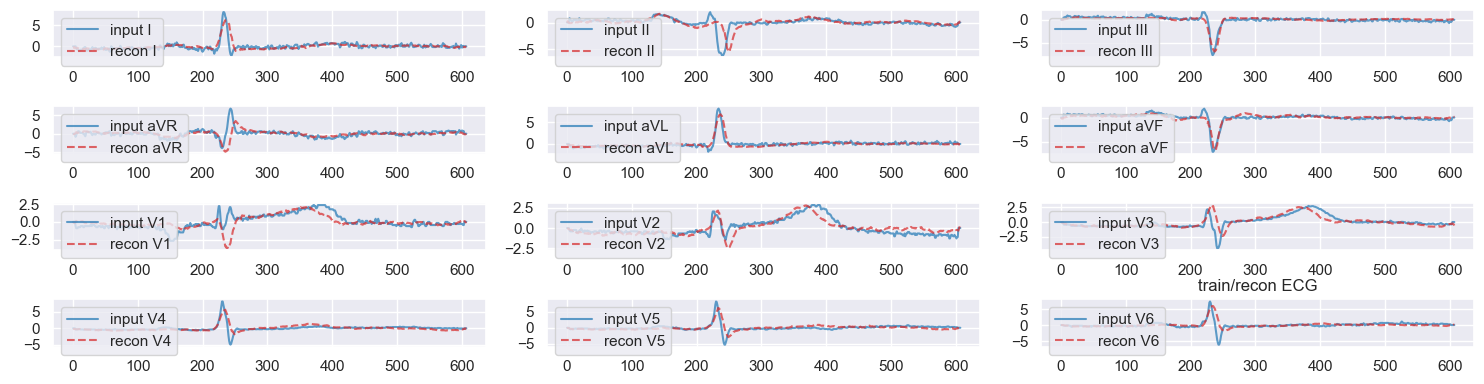

In [48]:
ecg_net.cuda()
reconstructed_signal = ecg_net(x.cuda(),mask=None)
figure = plot_overlapped_multi_lead_signals(x[0].cpu().numpy(),
                                            reconstructed_signal[0].detach().cpu().numpy(),
                                            labels = ["input ","recon "])

In [49]:
last_hidden_feature = classification_net.downsteam_net.get_features(z)
print(last_hidden_feature.shape)
hidden_z_dim = 28 ## the principle dimension of the hidden feature
## adjust the latent feature z so that the hidden feature in x74 is close to 1 ##
previous_z_74_value = last_hidden_feature[:,hidden_z_dim]
## plot the value of z_74
## get the minumum value and indices of z_74 
min_z_74, min_indice = torch.min(previous_z_74_value,dim=0)
max_z_74, max_indice = torch.max(previous_z_74_value,dim=0)
## median value of z_74
median_z_74, median_indice = torch.median(previous_z_74_value,dim=0)
## get z_74 with value close to median z_74
# median_z_74 = z[torch.abs(previous_z_74_value-median_z_74)<1e-10]
# print(median_z_74.shape)
print("the range of {} is: [{},{}]".format(str(hidden_z_dim),min_z_74,max_z_74))

torch.Size([44, 128])
the range of 28 is: [-0.6602615714073181,2.4219536781311035]


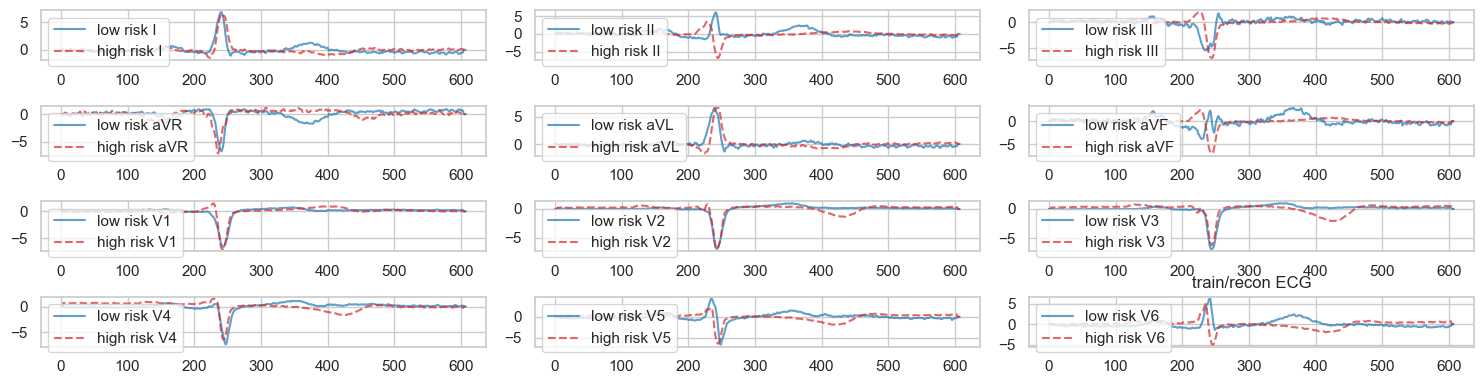

In [82]:
## get the z_133 
previous_z_133_value = z[:,133]
min_z, min_indice = torch.min(previous_z_133_value,dim=0)
max_z, max_indice = torch.max(previous_z_133_value,dim=0)
## plot the ECG recon signal with lowest z_74 value
figure = plot_overlapped_multi_lead_signals(filtered_x[min_indice].detach().cpu().numpy(),
                                   filtered_x[max_indice].detach().cpu().numpy(),
                                   labels = ["low risk ","high risk "])


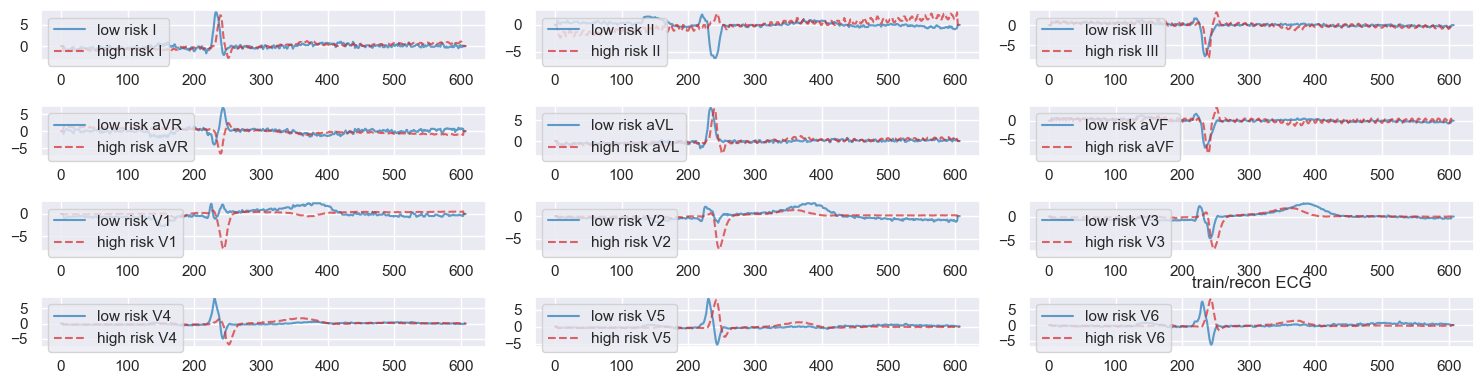

In [50]:
## plot the ECG recon signal with lowest z_74 value
figure = plot_overlapped_multi_lead_signals(filtered_x[min_indice].detach().cpu().numpy(),
                                   filtered_x[max_indice].detach().cpu().numpy(),
                                   labels = ["low risk ","high risk "])

In [84]:
## compute the incidence cases's z_74 value
import pandas as pd
MI_HF_coxreg_df= pd.read_csv('/home/engs2522/project/multi-modal-heart/multi_modal_heart/toolkits/ukb/non_imaging_information/MI/MI_HF_coxreg_df.csv')
MI_HF_coxreg_df.head(5)

,eid,HF_status,time_to_HF
0,1007100,0,274
1,1011223,0,246
2,1013662,0,387
3,1025631,0,274
4,1028018,0,405


In [85]:
incident_case = MI_HF_coxreg_df[MI_HF_coxreg_df['HF_status']==1]
h_74_list = []
z_feature_list =[]
hidden_feature_list= []
hidden_z_dim = 28
## latent z feature 
ecg_wave_tensor_list = []
duration_list = []
for eid, ecg_wave in  zip(eid_list_mi, hf_data):
    if eid in incident_case.eid.values:
        print (eid)
        # print (ecg_wave.shape)
        ecg_wave_tensor = torch.Tensor(ecg_wave).unsqueeze(0).float().cuda()
        duration = MI_HF_coxreg_df[MI_HF_coxreg_df['eid']==eid]["time_to_HF"].values[0]
        ecg_wave_tensor_list.append(ecg_wave_tensor)
        # z = classification_net.encoder.get_features_after_pooling(ecg_wave_tensor,mask=None)
        # print(z.shape)
        duration_list.append(duration)
batched_ecg_wave = torch.cat(ecg_wave_tensor_list,dim=0)
z_feature = classification_net.encoder.get_features_after_pooling(batched_ecg_wave,mask=None)
h_feature = classification_net.downsteam_net.get_features(z_feature)
hidden_dim =133
h_74_list = h_feature[:,hidden_z_dim].detach().cpu().numpy()
z_list =z_feature[:,hidden_dim].detach().cpu().numpy()
final_list  = [[h,z,d] for h,z,d in zip(h_74_list,z_list,duration_list)]

z_value_time_to_hf_df = pd.DataFrame(final_list,columns=[f"h_{hidden_z_dim}",f"z_{hidden_dim}","time_to_hf"])
# final_list[0].shape## plot the z_74 value with time to HF
z_value_time_to_hf_df.head()

1099680
1114489
1137126
1461526
1502448
1609346
1623584
2008392
2019107
2037761
2423238
2458996
2591841
2604953
2611922
2679089
2757191
2972649
3047014
3071443
3176139
3519054
3562794
3573301
3603085
3604874
3663712
3715423
3967839
4387163
4438583
4524745
4757788
4770738
5138481
5140974
5225380
5363922
5443459
5457994
5681859
5806149
5880752
5891306
5948866


,h_28,z_133,time_to_hf
0,-0.501394,0.825917,19
1,1.292526,-0.158879,230
2,-0.562894,-1.842665,97
3,1.546717,1.037735,235
4,-0.598149,-0.648918,15


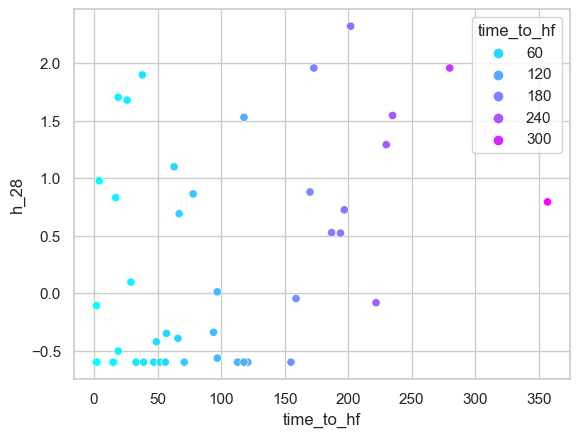

In [86]:
#plot the z_74 value with time to HF
import seaborn as sns
sns.set_theme(style="whitegrid")
## plot the z_74 value with time to HF as color
ax = sns.scatterplot(x="time_to_hf", y=f"h_{hidden_z_dim}", data=z_value_time_to_hf_df,hue="time_to_hf",palette="cool")

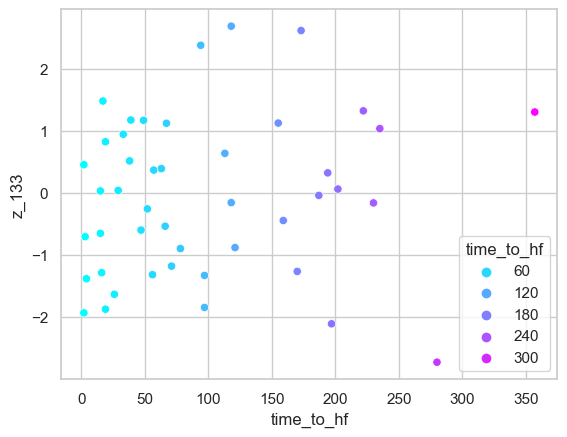

In [87]:
#plot the z_74 value with time to HF
import seaborn as sns
sns.set_theme(style="whitegrid")
## plot the z_74 value with time to HF as color
ax = sns.scatterplot(x="time_to_hf", y=f"z_{hidden_dim}", data=z_value_time_to_hf_df,hue="time_to_hf",palette="cool")

In [88]:
h_selected = last_hidden_feature[[min_indice],:]
print(h_selected.shape)
target_h_feature = h_selected.detach().clone()
target_h_feature[:,hidden_z_dim] = max_z_74 ## set the value of z_74 to 1 to increase the likelihood of HF
print (target_h_feature)
target_h_feature = target_h_feature.detach().clone()


torch.Size([1, 128])
tensor([[-0.6956,  1.4860, -0.6581,  1.7360, -0.3772, -0.6438,  0.4901, -0.5871,
         -0.6551, -0.2624, -0.7837, -0.5939,  0.9088, -0.5518, -0.6746, -0.3654,
          1.2380, -0.7619, -0.3648, -0.5623, -0.4429, -0.6279,  2.5727, -0.6380,
         -0.6098, -0.6201,  0.6013, -0.0700,  3.4516, -0.6591, -0.5427,  1.2023,
         -0.5512, -0.2570, -0.7370,  1.3893,  1.8334,  0.0574,  0.6822, -0.0308,
         -0.6628, -0.5671,  1.5899,  0.1026, -0.6319,  0.7645,  0.4348,  1.7697,
         -0.1553,  1.6183,  0.4172, -0.6497, -0.6814,  0.2996,  1.5122, -0.7118,
          0.3142,  0.6134,  0.5480, -0.6416, -0.1220,  2.1457, -0.5412,  0.8392,
         -0.5769, -0.1734,  1.6597, -0.7209,  1.1129,  1.7868, -0.0114, -0.4840,
          0.8993, -0.6290, -0.2015,  1.7925, -0.6884, -0.5293, -0.5429, -0.5575,
         -0.6048,  0.9580, -0.6056,  0.2603,  0.5812,  0.3800,  1.5622, -0.5753,
         -0.5667, -0.5167,  1.3124, -0.6299,  0.4526, -0.7454,  1.5604, -0.3015,
       

In [89]:
## perform optimization of latent code z so that hidden feature h matches the target hidden feature
from torch.optim import AdamW
from torch.nn import MSELoss, L1Loss
from tqdm import tqdm
z_selected= z[[min_indice],:].detach().clone()
z_selected_original = z_selected.detach().clone()
reconstructed_signal = ecg_net.decoder(z_selected)
target_h_feature = target_h_feature.detach().clone()
target_h_feature.requires_grad = False
z_selected.requires_grad = True
optimizer = AdamW([z_selected],lr=1e-3,weight_decay=1e-3)
loss_fn = MSELoss()
classification_net.unfreeze()
classification_net.eval()
for i in tqdm(range(2000)):
    optimizer.zero_grad()
    last_hidden_feature = classification_net.downsteam_net.get_features(z_selected)
    loss = loss_fn(input = last_hidden_feature[:,hidden_z_dim],target = target_h_feature[:,hidden_z_dim])
    loss.backward()
    optimizer.step()
    if i%100==0:
        print ("loss:{}".format(loss.item()))
        print ("h_28:{}".format(last_hidden_feature[:,hidden_z_dim]))
        ## measure the difference of the optimized value and the one before optimization
        print ("z difference:{}".format(torch.sum(torch.abs(z_selected_original-z_selected))))


  0%|          | 0/2000 [00:00<?, ?it/s]

  4%|▍         | 77/2000 [00:00<00:02, 768.40it/s]

loss:12.660900115966797
h_28:tensor([-0.1066], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:0.5121565461158752


  9%|▉         | 175/2000 [00:00<00:02, 889.36it/s]

loss:6.280185699462891
h_28:tensor([0.9456], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:48.65662384033203


 14%|█▍        | 280/2000 [00:00<00:01, 961.49it/s]

loss:2.724925994873047
h_28:tensor([1.8009], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:87.7564697265625
loss:1.0144139528274536
h_28:tensor([2.4444], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:117.15425109863281


 23%|██▎       | 465/2000 [00:00<00:02, 733.93it/s]

loss:0.31816983222961426
h_28:tensor([2.8875], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:137.37881469726562
loss:0.08308007568120956
h_28:tensor([3.1634], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:149.9578399658203


 35%|███▍      | 699/2000 [00:00<00:01, 739.81it/s]

loss:0.017943814396858215
h_28:tensor([3.3176], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:156.9893798828125
loss:0.0031960990745574236
h_28:tensor([3.3951], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:160.51773071289062
loss:0.00046949004172347486
h_28:tensor([3.4299], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:162.10910034179688


 50%|█████     | 1008/2000 [00:01<00:01, 808.05it/s]

loss:5.740644337492995e-05
h_28:tensor([3.4440], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:162.75592041015625
loss:6.085679615353001e-06
h_28:tensor([3.4491], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:162.99493408203125


 59%|█████▉    | 1175/2000 [00:01<00:01, 762.48it/s]

loss:6.544069606206904e-07
h_28:tensor([3.4508], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:163.07740783691406
loss:1.0176358955504838e-07
h_28:tensor([3.4513], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:163.10684204101562


 74%|███████▍  | 1475/2000 [00:01<00:00, 930.85it/s]

loss:3.6835956507275114e-08
h_28:tensor([3.4514], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:163.11978149414062
loss:3.087558297920623e-08
h_28:tensor([3.4514], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:163.12722778320312
loss:2.675028554222081e-08
h_28:tensor([3.4514], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:163.134521484375


 84%|████████▎ | 1673/2000 [00:01<00:00, 925.04it/s]

loss:2.263283249703818e-08
h_28:tensor([3.4514], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:163.1417694091797
loss:1.9854326183121884e-08
h_28:tensor([3.4515], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:163.1489715576172


 98%|█████████▊| 1965/2000 [00:02<00:00, 867.07it/s]

loss:1.707030605757609e-08
h_28:tensor([3.4515], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:163.15615844726562
loss:1.4727049801877001e-08
h_28:tensor([3.4515], device='cuda:0', grad_fn=<SelectBackward0>)
z difference:163.16329956054688


100%|██████████| 2000/2000 [00:02<00:00, 837.88it/s]


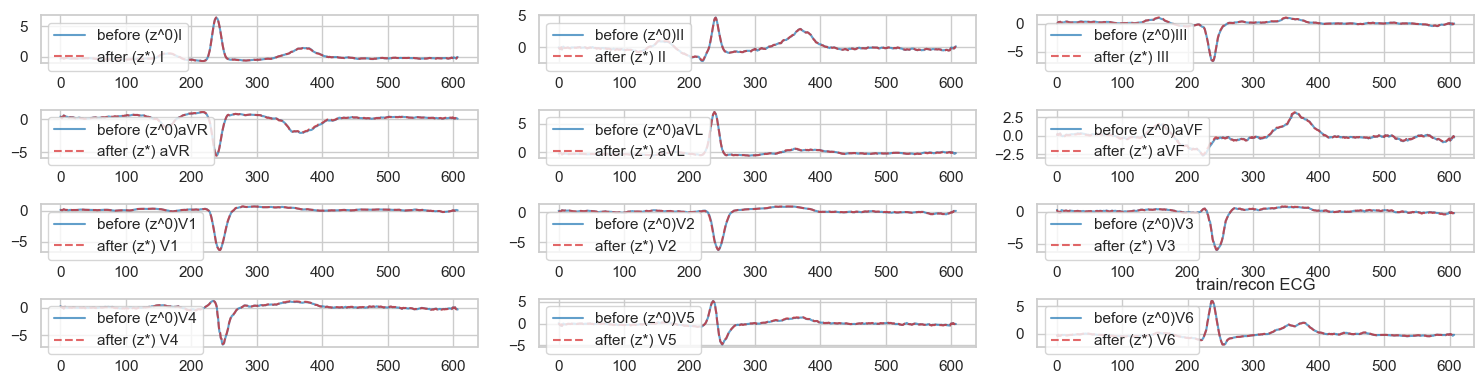

In [90]:
recon_selected = ecg_net.decoder(z_selected)
recon_original = ecg_net.decoder(z_selected_original)
figure = plot_overlapped_multi_lead_signals(recon_original[0].detach().cpu().numpy(),
                                            recon_selected[0].detach().cpu().numpy(),
                                            labels = ["before (z^0)","after (z*) "])

In [91]:
## directly optimize latent z
